In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
! pip install SimpleITK
import SimpleITK as sitk 

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.3 MB/s 


In [ ]:
import os
import numpy as np 
from PIL import Image
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt 
from skimage import color 
from skimage.transform import resize
import random 
import pandas as pd 
from sklearn.model_selection import train_test_split

In [ ]:
from torch.functional import Tensor
ultimate_path = '''/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip (Unzipped Files)/COVID-19_Radiography_Dataset''' 
path_to_normal = '{}/Normal/images'.format(ultimate_path)
path_to_covid = '{}/COVID/images'.format(ultimate_path)  
path_to_pneumonia = '{}/Viral Pneumonia/images'.format(ultimate_path)

num_samples = 1345 
filenames = random.sample(os.listdir(path_to_covid), num_samples) + random.sample(os.listdir(path_to_normal), 
                          num_samples) + random.sample(os.listdir(path_to_pneumonia), num_samples) 
classes = [] 
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        classes.append(1)
    if category == 'Normal':
        classes.append(0) 
    if category == 'Viral Pneumonia': 
        classes.append(2) 
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(path_to_covid, filenames[i])
    if 'Normal' in filenames[i]: 
        filenames[i] = os.path.join(path_to_normal, filenames[i])
    else:
        filenames[i] = os.path.join(path_to_pneumonia, filenames[i])
        
df = pd.DataFrame({'case' : filenames, 'class' : classes})

train_data, test_data = train_test_split(df, test_size = 0.2, train_size=0.8, 
                                         shuffle = True)
train_data, val_data = train_test_split(train_data, test_size = 0.1, train_size = 0.9, 
                                          shuffle = True) 

In [ ]:
class OurDataset(tc.utils.data.Dataset): 
  def __init__(self, df : pd.DataFrame): 
    self.cases = list(df.to_records(index=False))   
    
  def __len__(self): 
    return len(self.cases) 

  def __getitem__(self, idx): 
    current_case = self.cases[idx] 
    current_path = current_case[0] 
    current_class = int(current_case[1]) 
    current_image = Image.open(current_path)  
    # current_image = (current_image - np.min(current_image)) / (np.max(current_image) - np.min(current_image))  
    current_image = current_image.convert('RGB')
    # current_image = Image.fromarray(current_image)
    normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    data_transforms = tv.transforms.Compose([
        tv.transforms.Resize((224,224)),
        tv.transforms.ToTensor(),
        normalize
    ]) 
    current_image = data_transforms(current_image)
   
    np.seterr(invalid='ignore') 
    current_class = tc.as_tensor(current_class)
    return current_image, current_class

training_dataset = OurDataset(train_data) 
validation_dataset = OurDataset(val_data)  
testing_dataset = OurDataset(test_data)
batch_size = 16 
shuffle = True 
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size = batch_size, shuffle = shuffle) 
validation_dataloader =  tc.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle = shuffle)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size = 1, shuffle = False)

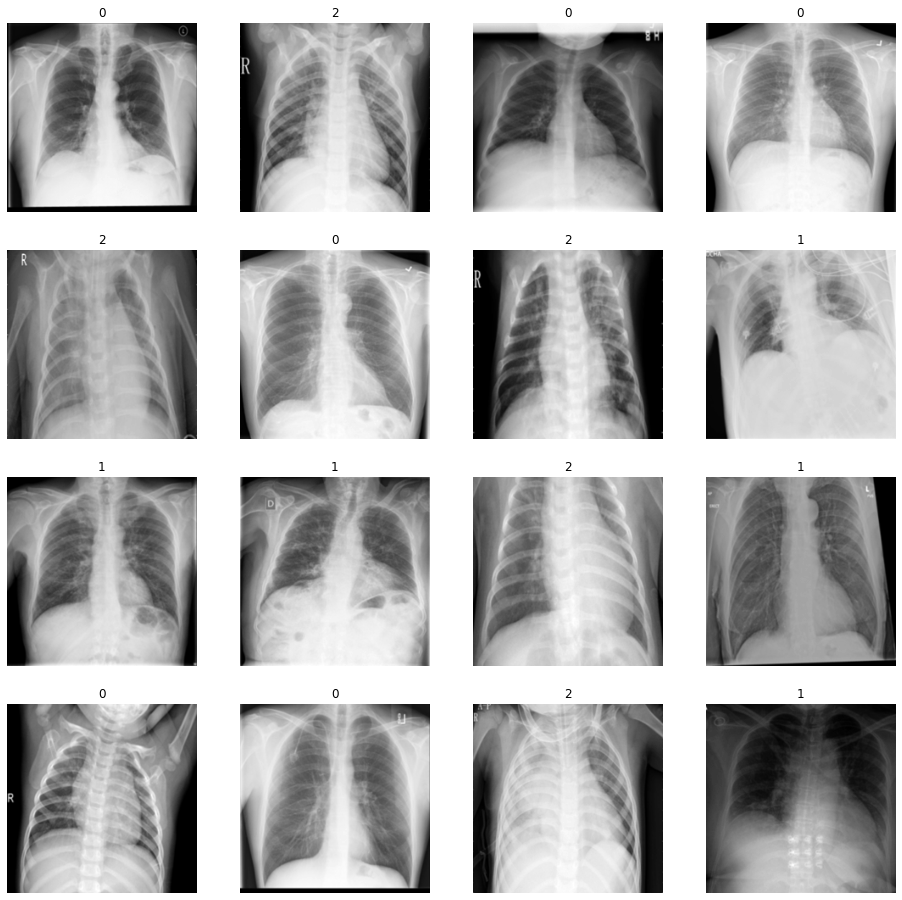

In [ ]:
i = 1 
fig = plt.figure(figsize=(16, 16)) 
for images, classes in training_dataloader: 
  if i > len(images): 
    break 
  fig.add_subplot(4, 4, i) 
  plt.axis('off')  
  plt.title(classes[0].item()) 
  plt.imshow(images[0][0], cmap="gray") 
  i += 1

In [ ]:
device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torchvision.models as models 
resnet50 = models.resnet50(pretrained=True) 
for params in resnet50.parameters(): 
  params.requires_grad = False 

In [ ]:
fc_inputs = resnet50.fc.in_features 
resnet50.fc = tc.nn.Sequential(
    tc.nn.BatchNorm1d(fc_inputs),
    tc.nn.Linear(fc_inputs, 128), 
    tc.nn.ReLU(), 
    tc.nn.Dropout(0.4), 
    tc.nn.Linear(128, 3), 
    tc.nn.Softmax(dim=1)
)
    
  
resnet50 = resnet50.to('cuda:0')

In [ ]:
loss_function = tc.nn.CrossEntropyLoss()
optimizer = tc.optim.Adam(resnet50.parameters())

In [ ]:
import time
def train_and_validate(model, loss_criterion, optimizer, epochs=15):

  start = time.time() 
  history = [] 
  best_loss = 100000.0 
  best_epoch = None 
  for epoch in range(epochs): 
    epoch_start = time.time() 
    print("Epoch: {}/{}".format(epoch+1, epochs)) 
    model.train() 
    train_loss = 0.0 
    train_acc = 0.0 
    valid_loss = 0.0 
    valid_acc = 0.0 
    for i, (images, classes) in enumerate(training_dataloader): 
      images = images.to(device) 
      classes = classes.to(device) 
      optimizer.zero_grad() 
      outputs = model(images) 
      loss = loss_criterion(outputs, classes)
      loss.backward() 
      optimizer.step() 
      train_loss += loss.item() * images.size(0) 
      ret, predictions = tc.max(outputs.data, 1) 
      correct_counts = predictions.eq(classes.data.view_as(predictions)) 
      acc = tc.mean(correct_counts.type(tc.FloatTensor)) 
      train_acc += acc.item() * images.size(0) 
    
    with tc.no_grad(): 
      
      model.eval() 
      for j, (images, classes) in enumerate(validation_dataloader): 
        images = images.to(device) 
        classes = classes.to(device) 
        outputs = model(images) 
        loss = loss_criterion(outputs, classes)
        valid_loss += loss.item() * images.size(0) 
        ret, predictions = tc.max(outputs.data, 1) 
        correct_counts = predictions.eq(classes.data.view_as(predictions)) 
        acc = tc.mean(correct_counts.type(tc.FloatTensor)) 
        valid_acc += acc.item() * images.size(0) 
      
      if valid_loss < best_loss: 
        best_loss = valid_loss 
        best_epoch = epoch 

      avg_train_loss = train_loss/len(training_dataloader.dataset)  
      avg_train_acc = train_acc/len(training_dataloader.dataset) 
      avg_valid_loss = valid_loss/len(validation_dataloader.dataset)  
      avg_valid_acc = valid_acc/len(validation_dataloader.dataset)  

      history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc]) 
      epoch_end = time.time() 
      
      print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


  return model, history, best_epoch

In [ ]:
num_epochs = 50
trained_model, history, best_epoch = train_and_validate(resnet50, loss_function, optimizer, num_epochs)

Epoch: 1/50
Epoch : 000, Training: Loss - 0.7199, Accuracy - 83.2014%, 
		Validation : Loss - 0.6589, Accuracy - 88.8545%, Time: 30.1210s
Epoch: 2/50
Epoch : 001, Training: Loss - 0.6650, Accuracy - 88.6747%, 
		Validation : Loss - 0.6372, Accuracy - 91.6409%, Time: 30.9401s
Epoch: 3/50
Epoch : 002, Training: Loss - 0.6490, Accuracy - 90.0861%, 
		Validation : Loss - 0.6306, Accuracy - 91.6409%, Time: 25.3629s
Epoch: 4/50
Epoch : 003, Training: Loss - 0.6513, Accuracy - 89.6386%, 
		Validation : Loss - 0.6333, Accuracy - 91.6409%, Time: 31.0949s
Epoch: 5/50
Epoch : 004, Training: Loss - 0.6455, Accuracy - 90.1893%, 
		Validation : Loss - 0.6124, Accuracy - 93.4985%, Time: 25.4147s
Epoch: 6/50
Epoch : 005, Training: Loss - 0.6435, Accuracy - 90.4647%, 
		Validation : Loss - 0.6203, Accuracy - 93.1889%, Time: 25.6271s
Epoch: 7/50
Epoch : 006, Training: Loss - 0.6480, Accuracy - 90.0861%, 
		Validation : Loss - 0.6355, Accuracy - 90.7121%, Time: 25.4934s
Epoch: 8/50
Epoch : 007, Training:

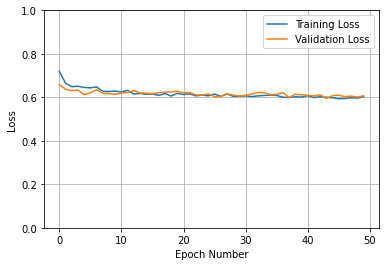

In [ ]:
history = np.array(history) 
plt.plot(history[:,0:2]) 
plt.legend(['Training Loss', 'Validation Loss'])  
plt.xlabel('Epoch Number') 
plt.ylabel('Loss') 
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

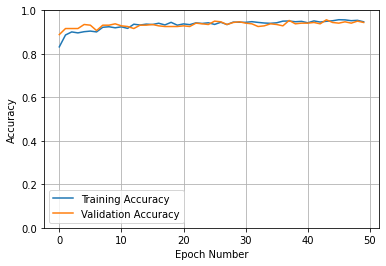

In [ ]:
plt.plot(history[:,2:4]) 
plt.legend(['Training Accuracy', 'Validation Accuracy'])  
plt.xlabel('Epoch Number') 
plt.ylabel('Accuracy') 
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

In [ ]:
def ComputeTestAccuracy(model, loss_criterion): 
  
  device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu") 
  test_acc = 0.0 
  test_loss = 0.0 
  pred = []
  tar = []
  with tc.no_grad(): 
    model.eval() 
    for j, (images, classes) in enumerate(testing_dataloader): 
      images = images.to(device) 
      classes = classes.to(device) 
      outputs = model(images) 
      loss = loss_criterion(outputs, classes) 
      test_loss += loss.item() * images.size(0) 
      ret, predictions = tc.max(outputs.data, 1) 
      pred.extend(predictions.cpu().numpy().tolist()) 
      tar.extend(classes.cpu().numpy().tolist()) 
      correct_counts = predictions.eq(classes.data.view_as(predictions)) 
      acc = tc.mean(correct_counts.type(tc.FloatTensor)) 
      test_acc += acc.item() * images.size(0) 
      # print("Test Batch number {:3d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item())) 

    avg_test_loss = test_loss/len(training_dataloader.dataset)  
    avg_test_acc = test_acc/len(training_dataloader.dataset)  
  return tar, pred

    #  print("Test accuracy: {}".format(str))

In [ ]:
from sklearn.metrics import confusion_matrix
t, p = ComputeTestAccuracy(trained_model, loss_function) 
cm = confusion_matrix(t, p) 
cm

array([[244,  14,   4],
       [ 25, 257,   1],
       [ 17,   1, 244]])

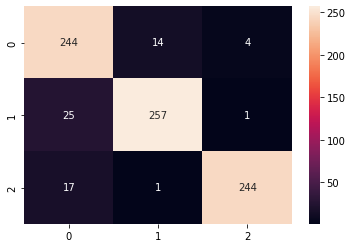

In [ ]:
import seaborn as sns 
sns.heatmap(cm, annot=True, fmt='d')